# Comparison between Nestorov and normal momentum approaches 

## Import libreries and define global variables

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from NeuralNetwork import NeuralNetwork
from utils import get_data, onehot_encoding, grid_search, save_dict_to_file, load_dict_from_file
from Layer import Layer, Input
from functions import accuracy, MSE, MEE
import pandas as pd

In [2]:
DIR = '/Users/HP/Desktop/UNI/LM_1/MachineLearning/ML_prj/' # Directory of the package.

## Import datasets

### Import MONK datasets

In [3]:
df = get_data(f'{DIR}data/MONK/monks-1.train')
df_test = get_data(f'{DIR}data/MONK/monks-1.test')

X_train_monk, y_train_monk = df.drop(columns=['target','id']).to_numpy().T, df['target'].apply(lambda x: int(x)).to_numpy().T
X_test_monk, y_test_monk = df_test.drop(columns=['target','id']).to_numpy().T, df_test['target'].apply(lambda x: int(x)).to_numpy().T

### Import CUP dataset

Define the fraction of dataset which will represent the internal test set.

In [4]:
test_frac = 1/4

In [5]:
names = ['id', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 
         'feature_7', 'feature_8', 'feature_9', 'feature_10', 'target_x', 'target_y','target_z']

df = pd.read_csv(f"{DIR}data/ML-CUP23-TR.csv", names=names, comment='#')

targets = ['target_x', 'target_y', 'target_z']
features = list(set(names) - {'id', 'target_x', 'target_y', 'target_z'})

df = df.sample(frac=1)

train_test_div = round((1-test_frac) * df.shape[0])

X_train_cup, y_train_cup = df[:train_test_div][features].to_numpy().T, df[:train_test_div][targets].to_numpy().T
X_test_cup, y_test_cup = df[train_test_div:][features].to_numpy().T, df[train_test_div:][targets].to_numpy().T

## Data preprocessing

### MONK preprocessing

Process one hot encoding on training and test sets.

In [6]:
X_train_monk = onehot_encoding(X_train_monk)
X_test_monk = onehot_encoding(X_test_monk)

### CUP preprocessing

Decide which data preprocessing method apply to cup training set:
+ MinMax normalization (preprocessing = 1)
+ Standardization (preprocessing = 2)

In [7]:
def standardize(input_array):
    """
    Standardize each feature in an input array using Z-score standardization.

    Parameters:
    - input_array (numpy.ndarray): Input array with dimensions (features, samples).

    Returns:
    - numpy.ndarray: Standardized input array.
    """
    mean_vals = np.mean(input_array, axis=1, keepdims=True)
    std_dev_vals = np.std(input_array, axis=1, keepdims=True)

    # Ensure no division by zero
    std_dev_vals[std_dev_vals == 0] += 1e-6

    standardized_array = (input_array - mean_vals) / std_dev_vals

    return standardized_array


In [8]:
def minmax_norm(input_array):
    X_train_norm = []
    for elem in input_array:
        X_train_norm.append((elem - np.min(elem)) / (np.max(elem) - np.min(elem)))
    return np.array(X_train_norm)

In [9]:

X_train_norm = minmax_norm(X_train_cup)
X_test_norm = minmax_norm(X_test_cup)

X_train_stand = standardize(X_train_cup)
X_test_stand = standardize(X_test_cup)

## CUP

Define training and model hyperparameters

In [10]:
orig_params = {'hidden_dim': 50,
        'hidden_act_func': 'tanh',
        'hidden_dim2': 50,
        'hidden_act_func2' : 'tanh',
        'eta': 0.001,
        'lam': 0.000,
        'alpha': 0.9,
        'n_batch': 150,
        'use_opt':0,
        'nest': True,
        'l1_reg' : False,
        'epochs' : 500,
        'loss' : 'MSE',
        'output_act_func': 'lin'
        }
seed = np.random.randint(10,1000)

### No normalization

Build model

In [11]:
params = orig_params.copy()
input_layer = Input(X_train_cup.shape[0])
hidden_layer = Layer(input_layer, params.pop('hidden_dim'), params.pop('hidden_act_func'))
o = 2
while True:
    if f'hidden_dim{o}' in params.keys():
        hidden_layer = Layer(hidden_layer, params.pop(f'hidden_dim{o}'), params.pop(f'hidden_act_func{o}'))
        o += 1
    else: break
output_layer = Layer(hidden_layer, 3, params.pop('output_act_func'))

model = NeuralNetwork(input_layer, output_layer, params.pop('loss'), metrics=[MEE])

init_weights_list = model.get_weights_list()

Training:

In [12]:
np.random.seed(seed)
history_nonorm = model.retrain(X_train_cup, y_train_cup,
                                    ** params,
                                    test_data=[X_test_cup, y_test_cup],
                                    early_stopping=None,
                                    reduce_eta=None
                                    )

Epoch 0: train_loss: 5.761e+02, test_loss: 5.367e+02; train_MEE: 3.651e+01, test_MEE: 3.519e+01  lr : 0.001
Epoch 1: train_loss: 2.614e+02, test_loss: 2.347e+02; train_MEE: 2.377e+01, test_MEE: 2.249e+01  lr : 0.001
Epoch 2: train_loss: 8.899e+01, test_loss: 7.661e+01; train_MEE: 1.408e+01, test_MEE: 1.326e+01  lr : 0.001
Epoch 3: train_loss: 3.895e+01, test_loss: 3.487e+01; train_MEE: 9.572e+00, test_MEE: 9.229e+00  lr : 0.001
Epoch 4: train_loss: 2.324e+01, test_loss: 2.235e+01; train_MEE: 7.561e+00, test_MEE: 7.325e+00  lr : 0.001
Epoch 5: train_loss: 1.756e+01, test_loss: 1.768e+01; train_MEE: 6.368e+00, test_MEE: 6.341e+00  lr : 0.001
Epoch 6: train_loss: 1.240e+01, test_loss: 1.356e+01; train_MEE: 5.090e+00, test_MEE: 5.361e+00  lr : 0.001
Epoch 7: train_loss: 9.500e+00, test_loss: 1.045e+01; train_MEE: 4.484e+00, test_MEE: 4.702e+00  lr : 0.001
Epoch 8: train_loss: 7.514e+00, test_loss: 7.879e+00; train_MEE: 3.906e+00, test_MEE: 3.982e+00  lr : 0.001
Epoch 9: train_loss: 6.138e+

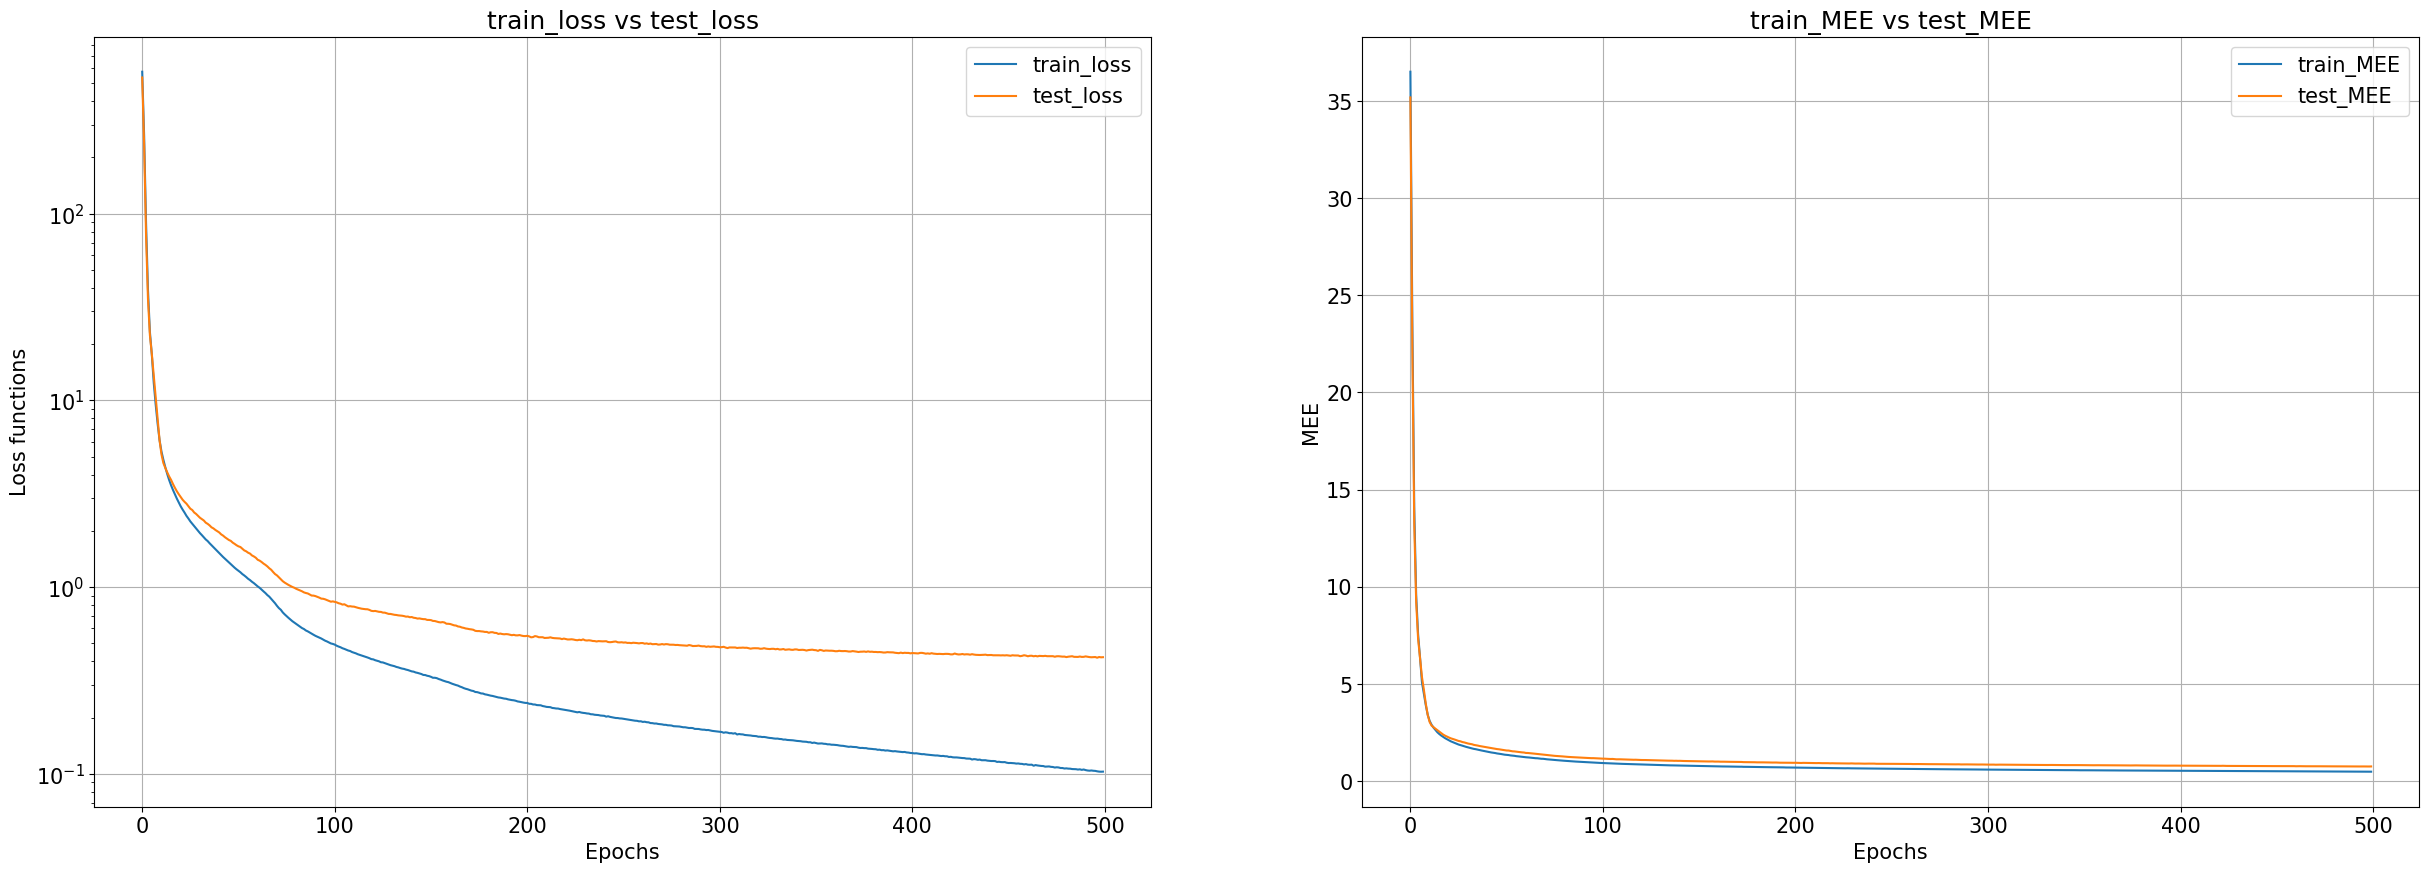

In [13]:
plt.figure(1,figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history_nonorm['train_loss'],label='train_loss')
plt.plot(history_nonorm['test_loss'], label='test_loss')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs test_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(history_nonorm['train_MEE'],label='train_MEE')
plt.plot(history_nonorm['test_MEE'], label='test_MEE')
plt.xlabel('Epochs', size=15)
plt.ylabel('MEE', size=15)
plt.title('train_MEE vs test_MEE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)

### minmax normalization


Build model


In [14]:
params = orig_params.copy()
input_layer = Input(X_train_cup.shape[0])
hidden_layer = Layer(input_layer, params.pop('hidden_dim'), params.pop('hidden_act_func'))
o = 2
while True:
    if f'hidden_dim{o}' in params.keys():
        hidden_layer = Layer(hidden_layer, params.pop(f'hidden_dim{o}'), params.pop(f'hidden_act_func{o}'))
        o += 1
    else: break
output_layer = Layer(hidden_layer, 3, params.pop('output_act_func'))

model = NeuralNetwork(input_layer, output_layer, params.pop('loss'), metrics=[MEE])

model.set_initial_weights(init_weights_list)

Training:


In [15]:
np.random.seed(seed)
history_norm = model.retrain(X_train_norm, y_train_cup,
                                    ** params,
                                    test_data=[X_test_cup, y_test_cup],
                                    early_stopping=None,
                                    reduce_eta=None
                                    )

Epoch 0: train_loss: 6.091e+02, test_loss: 5.865e+02; train_MEE: 3.884e+01, test_MEE: 3.743e+01  lr : 0.001
Epoch 1: train_loss: 3.858e+02, test_loss: 3.477e+02; train_MEE: 3.129e+01, test_MEE: 2.867e+01  lr : 0.001
Epoch 2: train_loss: 1.832e+02, test_loss: 1.935e+02; train_MEE: 2.030e+01, test_MEE: 2.227e+01  lr : 0.001
Epoch 3: train_loss: 7.594e+01, test_loss: 1.262e+02; train_MEE: 1.282e+01, test_MEE: 1.830e+01  lr : 0.001
Epoch 4: train_loss: 3.593e+01, test_loss: 1.153e+02; train_MEE: 9.245e+00, test_MEE: 1.714e+01  lr : 0.001
Epoch 5: train_loss: 1.875e+01, test_loss: 1.134e+02; train_MEE: 6.560e+00, test_MEE: 1.669e+01  lr : 0.001
Epoch 6: train_loss: 1.162e+01, test_loss: 1.114e+02; train_MEE: 5.135e+00, test_MEE: 1.658e+01  lr : 0.001
Epoch 7: train_loss: 8.825e+00, test_loss: 1.092e+02; train_MEE: 4.457e+00, test_MEE: 1.657e+01  lr : 0.001
Epoch 8: train_loss: 6.959e+00, test_loss: 1.082e+02; train_MEE: 3.880e+00, test_MEE: 1.660e+01  lr : 0.001
Epoch 9: train_loss: 5.680e+

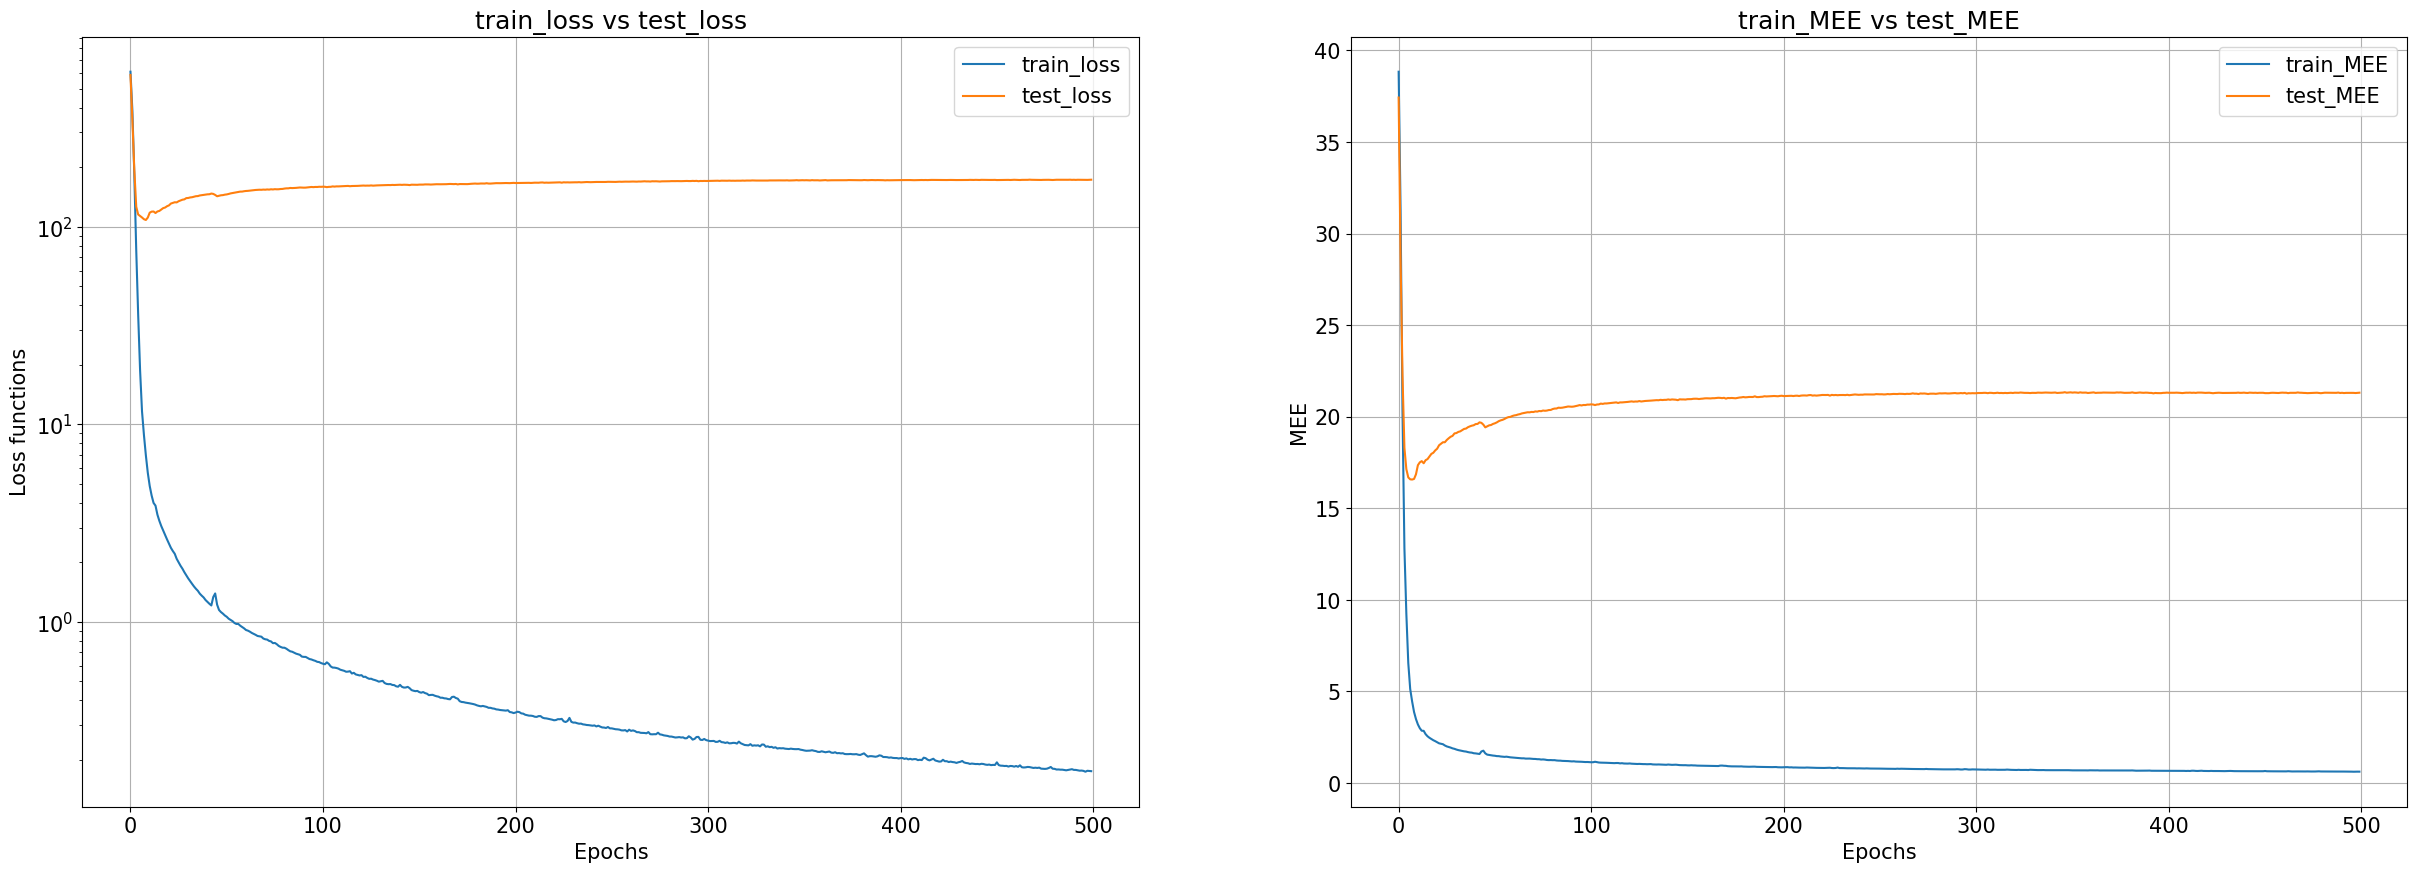

In [16]:
plt.figure(1,figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history_norm['train_loss'],label='train_loss')
plt.plot(history_norm['test_loss'], label='test_loss')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs test_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(history_norm['train_MEE'],label='train_MEE')
plt.plot(history_norm['test_MEE'], label='test_MEE')
plt.xlabel('Epochs', size=15)
plt.ylabel('MEE', size=15)
plt.title('train_MEE vs test_MEE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)


### standardization


Build model


In [ ]:
params = orig_params.copy()
input_layer = Input(X_train_cup.shape[0])
hidden_layer = Layer(input_layer, params.pop('hidden_dim'), params.pop('hidden_act_func'))
o = 2
while True:
    if f'hidden_dim{o}' in params.keys():
        hidden_layer = Layer(hidden_layer, params.pop(f'hidden_dim{o}'), params.pop(f'hidden_act_func{o}'))
        o += 1
    else: break
output_layer = Layer(hidden_layer, 3, params.pop('output_act_func'))

model = NeuralNetwork(input_layer, output_layer, params.pop('loss'), metrics=[MEE])

model.set_initial_weights(init_weights_list)

Training:


In [ ]:
np.random.seed(seed)
history_stand = model.retrain(X_train_stand, y_train_cup,
                                    ** params,
                                    test_data=[X_test_cup, y_test_cup],
                                    early_stopping=None,
                                    reduce_eta=None
                                    )

Epoch 0: train_loss: 6.262e+02, val_loss: 6.259e+02; train_MEE: 3.848e+01, val_MEE: 3.866e+01  lr : 0.001
Epoch 1: train_loss: 3.422e+02, val_loss: 3.418e+02; train_MEE: 2.764e+01, val_MEE: 2.770e+01  lr : 0.001
Epoch 2: train_loss: 1.343e+02, val_loss: 1.300e+02; train_MEE: 1.731e+01, val_MEE: 1.697e+01  lr : 0.001
Epoch 3: train_loss: 5.469e+01, val_loss: 5.119e+01; train_MEE: 1.145e+01, val_MEE: 1.104e+01  lr : 0.001
Epoch 4: train_loss: 3.519e+01, val_loss: 3.145e+01; train_MEE: 9.243e+00, val_MEE: 8.628e+00  lr : 0.001
Epoch 5: train_loss: 2.346e+01, val_loss: 2.370e+01; train_MEE: 7.526e+00, val_MEE: 7.403e+00  lr : 0.001
Epoch 6: train_loss: 1.788e+01, val_loss: 2.016e+01; train_MEE: 6.496e+00, val_MEE: 6.685e+00  lr : 0.001
Epoch 7: train_loss: 1.352e+01, val_loss: 1.680e+01; train_MEE: 5.603e+00, val_MEE: 5.956e+00  lr : 0.001
Epoch 8: train_loss: 1.024e+01, val_loss: 1.431e+01; train_MEE: 4.820e+00, val_MEE: 5.337e+00  lr : 0.001
Epoch 9: train_loss: 8.487e+00, val_loss: 1.26

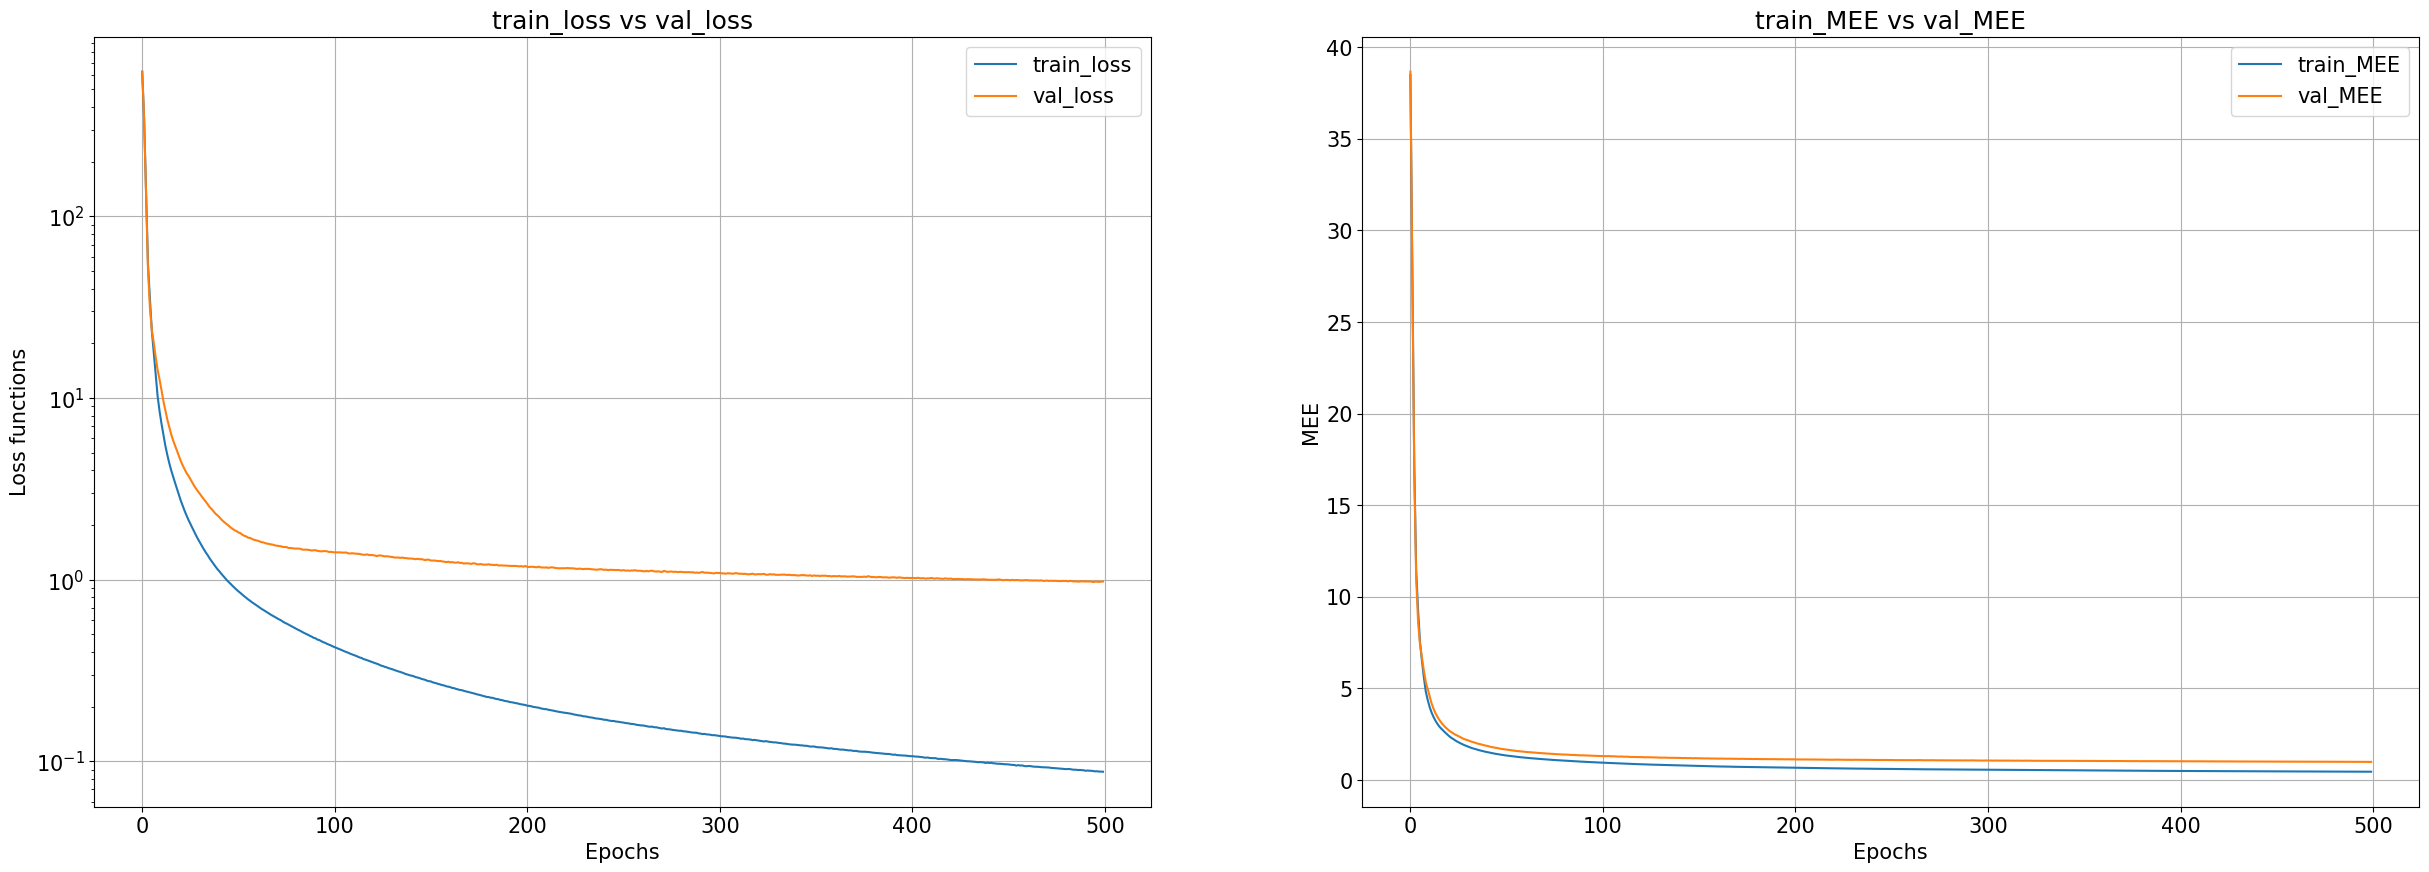

In [ ]:
plt.figure(1,figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history_stand['train_loss'],label='train_loss')
plt.plot(history_stand['test_loss'], label='test_loss')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs test_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(history_stand['train_MEE'],label='train_MEE')
plt.plot(history_stand['test_MEE'], label='test_MEE')
plt.xlabel('Epochs', size=15)
plt.ylabel('MEE', size=15)
plt.title('train_MEE vs test_MEE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)


### Comparison

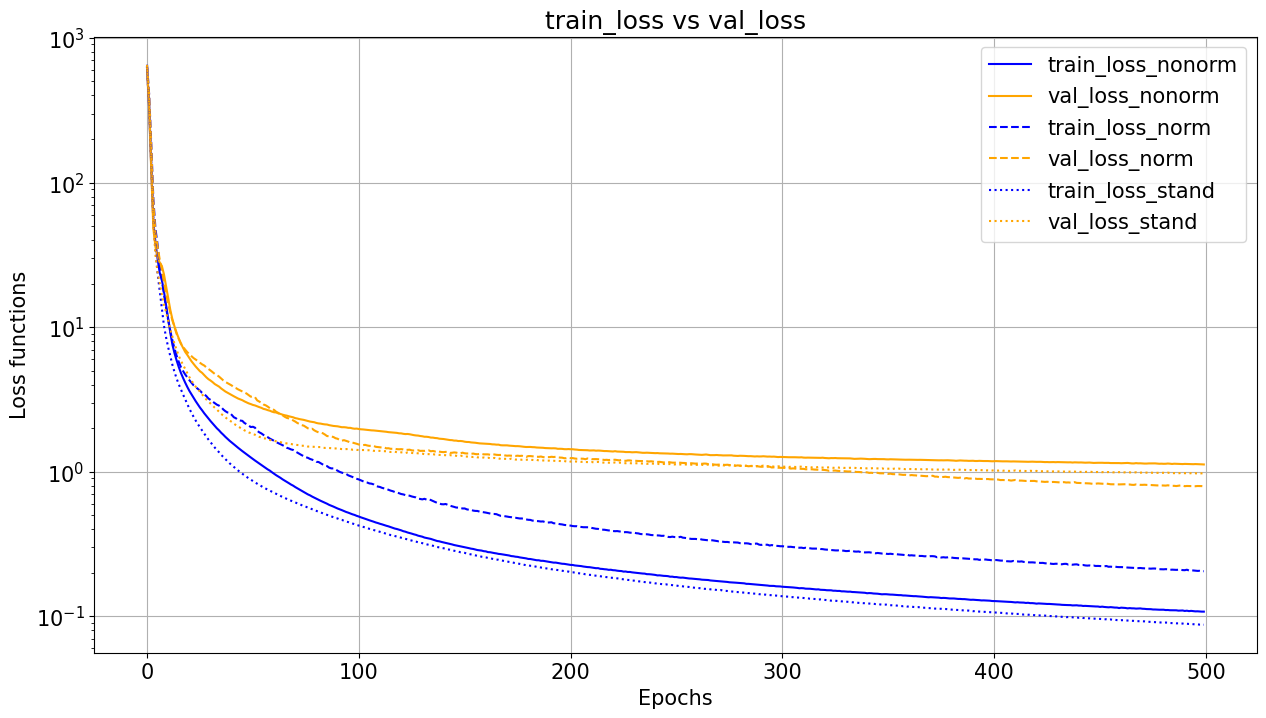

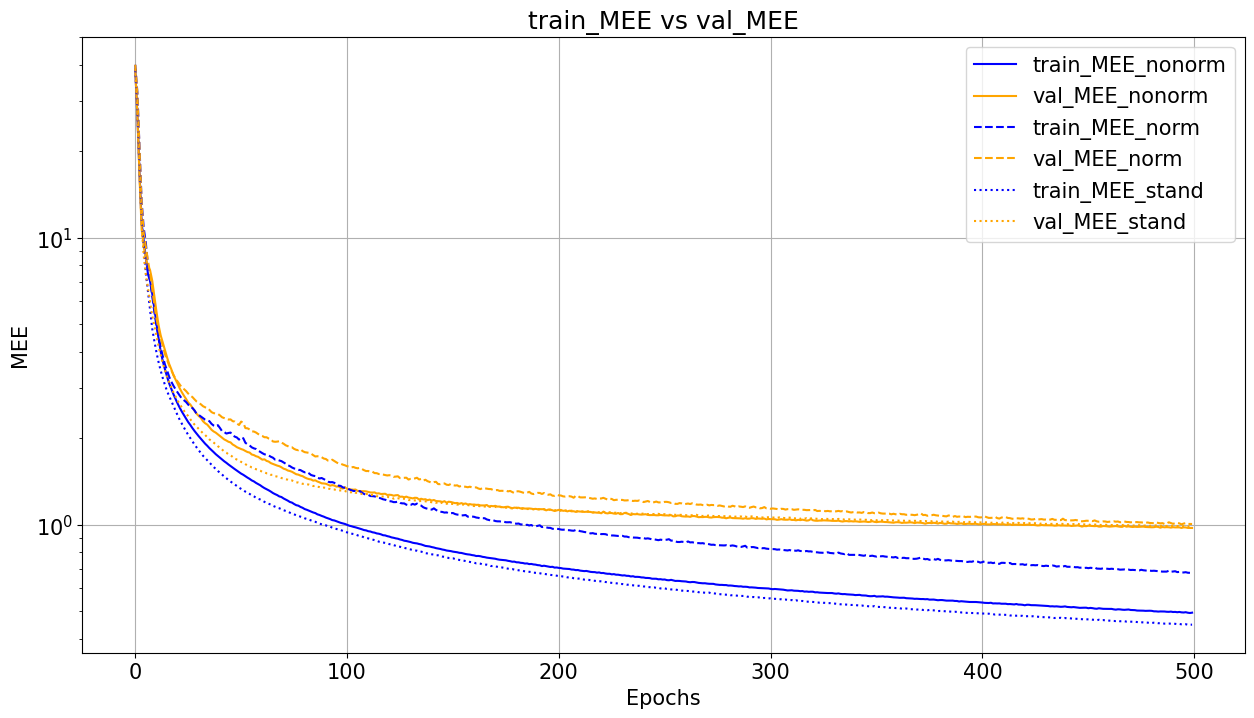

In [ ]:
plt.figure(1,figsize=(15,8))
#plt.subplot(1,2,1)
plt.plot(history_nonorm['train_loss'], '-', label='train_loss_nonorm', color='blue')
plt.plot(history_nonorm['test_loss'], '-', label='test_loss_nonorm', color='orange')
plt.plot(history_norm['train_loss'], '--', label='train_loss_norm', color='blue')
plt.plot(history_norm['test_loss'], '--', label='test_loss_norm', color='orange')
plt.plot(history_stand['train_loss'], linestyle='dotted', label='train_loss_stand', color='blue')
plt.plot(history_stand['test_loss'], linestyle='dotted', label='test_loss_stand', color='orange')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs test_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.figure(2,figsize=(15,8))
#plt.subplot(1,2,2)
plt.plot(history_nonorm['train_MEE'], '-',label='train_MEE_nonorm', color='blue')
plt.plot(history_nonorm['test_MEE'], '-', label='test_MEE_nonorm', color='orange')
plt.plot(history_norm['train_MEE'], '--', label='train_MEE_norm', color='blue')
plt.plot(history_norm['test_MEE'], '--', label='test_MEE_norm', color='orange')
plt.plot(history_stand['train_MEE'], linestyle='dotted', label='train_MEE_stand', color='blue')
plt.plot(history_stand['test_MEE'], linestyle='dotted', label='test_MEE_stand', color='orange')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('MEE', size=15)
plt.title('train_MEE vs test_MEE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)